In [1]:
import numpy as np
import pandas as pd
import json
from PIL import Image
import matplotlib.pyplot as plt
import requests
import torch
from transformers import MllamaForConditionalGeneration, AutoProcessor
import os
import glob
from tqdm import trange
from MMObject.llama import Llama32
from MMObject.utls import *
from MMObject.prompt_generator import *
import torch.nn.functional as F

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
val_aokvqa, coco_val_caption, coco_id_filename = prepare_dataset()

In [4]:
llama_model = Llama32()

Loading checkpoint shards: 100%|██████████| 5/5 [02:42<00:00, 32.44s/it]


In [5]:
model = llama_model.model
processor = llama_model.processor



In [6]:
base_path = "/home/ubuntu/data/coco/val2017/"

In [7]:
sub_ds = val_aokvqa[:2]

In [12]:

prompt_template = """
You task is to select one of the four following options based on the image and the question. Specifically, you need to output {{0}} or {{1}} or {{2}}or {{3}} surrounded by curly braces as well as rationales of why you chose that option.
The rationales should also include in curly braces the answer to the question.

Here are some examples that you can follow:
{}

Now, it's your turn. Again, remember to put your answer in curly braces. Here is the question you need to answer.
"""
pg0123 = PromptGenerator0123(prompt_template = prompt_template)
prompt_template = pg0123.generate_template(val_aokvqa[:3])

In [15]:
print(prompt_template)


You task is to select one of the four following options based on the image and the question. Specifically, you need to output {0} or {1} or {2}or {3} surrounded by curly braces as well as rationales of why you chose that option.
The rationales should also include in curly braces the answer to the question.

Here are some examples that you can follow:
Question: What is in the motorcyclist's mouth?
Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
Rationale: {He's smoking while riding.The motorcyclist has a lit cigarette in his mouth while he rides on the street.The man is smoking.}
Answer: {3}
Question: Which number birthday is probably being celebrated?
Choices: 0. one 1. ten 2. nine 3. thirty
Rationale: {There is a birthday cake on the table with the number 30 written in icing.The cake says 30.The numerals three and zero are written on the cake, which indicates the person is 30 years of age as of the birthdate.}
Answer: {3}
Question: What best describes the pool of water?


In [10]:
# from transformers import AutoConfig

# model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
# config = AutoConfig.from_pretrained(model_name)
# print(config)

In [9]:
# out = llama_model.predict_one(img_paths[0], "What did you see?", {"max_new_tokens":200})
# print(llama_model.processor.decode(out[0]))

In [17]:
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Preprocess the images and input text
inputs = processor(
    [img for img, _ in image_placeholder_pairs],  # Pass all images as a batch
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

extra_configs = {"max_new_tokens":100, 
                #  "output_scores":True,
                #  "return_dict_in_generate":True
                 }

for k, v in extra_configs.items():
    inputs[k] = v

raw_output = model.generate(**inputs)


OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacity of 21.98 GiB of which 64.44 MiB is free. Including non-PyTorch memory, this process has 21.90 GiB memory in use. Of the allocated memory 21.12 GiB is allocated by PyTorch, and 498.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [19]:
print(torch.cuda.memory_summary(device=torch.device('cuda:0')))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  21623 MiB |  21718 MiB |  36282 MiB |  14658 MiB |
|       from large pool |  21622 MiB |  21716 MiB |  36221 MiB |  14599 MiB |
|       from small pool |      1 MiB |      2 MiB |     60 MiB |     58 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  21623 MiB |  21718 MiB |  36282 MiB |  14658 MiB |
|       from large pool |  21622 MiB |  21716 MiB |  36221 MiB |

In [68]:
processor.decode(raw_output[0])

'<|begin_of_text|>def modify_list(input_list):\n    """\n    This function modifies the input list by adding a new element at the beginning and end of the list.\n    \n    Parameters:\n    input_list (list): The input list to be modified.\n    \n    Returns:\n    list: The modified list with a new element at the beginning and end.\n    """\n    \n    # Create a new list with the same elements as the input list\n    new_list = input_list.copy()\n    \n    # Add a new element at the beginning of the new list\n    new_list.insert(0, "New element at the beginning")\n    \n    # Add a new element at the end of the new list\n    new_list.append("New element at the end")\n    \n    # Return the modified list\n    return new_list\n\n# Test the function\ninput_list = [1, 2, 3, 4, 5]\nprint(modify_list(input_list))  # Output: [\'New element at the beginning'

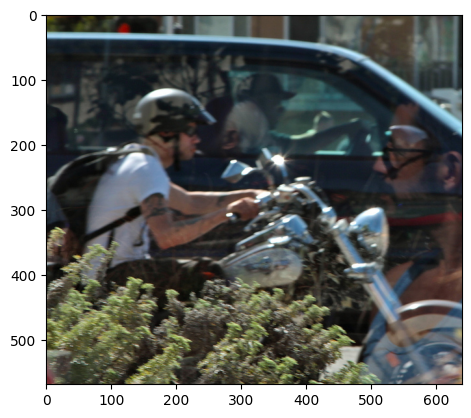

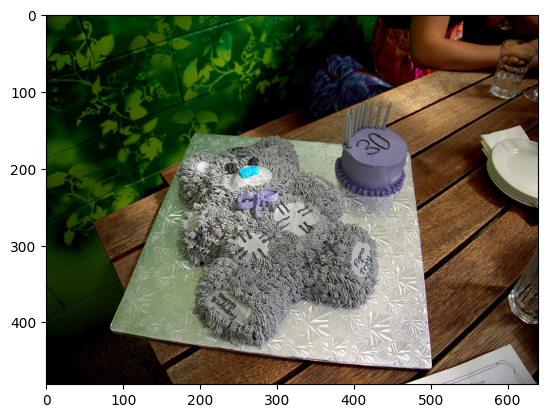

In [69]:
for p in img_paths:
    img = Image.open(p)
    plt.imshow(img)
    plt.show()

In [70]:
raw_output[0]

tensor([128000,    755,   5719,   2062,   5498,   2062,    997,    262,   3270,
           262,   1115,    734,  84049,    279,   1988,   1160,    555,   7999,
           264,    502,   2449,    520,    279,   7314,    323,    842,    315,
           279,   1160,    627,   1084,    262,  13831,    512,    262,   1988,
          2062,    320,   1638,   1680,    578,   1988,   1160,    311,    387,
         11041,    627,   1084,    262,   5295,    512,    262,   1160,     25,
           578,  11041,   1160,    449,    264,    502,   2449,    520,    279,
          7314,    323,    842,    627,    262,   3270,   1084,    262,    674,
          4324,    264,    502,   1160,    449,    279,   1890,   5540,    439,
           279,   1988,   1160,    198,    262,    502,   2062,    284,   1988,
          2062,  12511,    746,   1084,    262,    674,   2758,    264,    502,
          2449,    520,    279,   7314,    315,    279,    502,   1160,    198,
           262,    502,   2062,   7175, 

In [7]:
s = """
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>
You task is to select one of the four following options based on the image and the question. Specifically, you need to output 0 or 1 or 2 or 3 as well as rationales of why you chose that option.
The rationales should also include in curly braces the answer to the question.

Here are some examples that you can follow:
Question: What is in the motorcyclist's mouth?
Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
Rationale: Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth.

Question: Which number birthday is probably being celebrated?
Choices: 0. one 1. ten 2. nine 3. thirty
Rationale: From the question, we know that someone is celebrating for the birthday. Looking at the picture, we can see two things on the table top. One is a grey bear which is likely to be a cake, the other is a cake with several candles on it. By looking at the purple cake, we can see it writes number thirty on it.

Question: What best describes the pool of water?
Choices: 0. frozen 1. fresh 2. dirty 3. boiling
Rationale: Looking at the picture, we can see a tree in the middle. Behind the tree, we can see several giraffes. On the bottom of the picture, we can see a pool of water. This refers to the pool mentioned in the question. The pool is dark brown and it is brown and surrounded with mud. So the pool is dirty.

Now, it's your turn. Again, remember to put your answer in curly braces. Here is the question you need to answer.
Here is the OCR result of the image. You can refer to this information to answer the question. Remember the OCR result is not always accurate.
       
 OCR result: Ricola
 Now, here is the question you need to answer.
    Question: What item on the desk could help with a cold?
Choices: 0. cough drops 1. syringe 2. pills 3. herbal tea
Now Please answer the following question based on the image and the OCR result. You should first output Rational and then the answer.
 Now, please output the rational step by step.
 Rational:<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The image shows a person sitting at a desk with a laptop and various items on it. The person is holding a book or notebook in their hands, and there are several other objects on the desk, including a bag of Ricola cough drops, a box of tissues, and a glass of water.

To determine which item on the desk could help with a cold, we need to consider the purpose of each item. The laptop is likely being used for work or communication, but it is not directly related to treating a cold. The book or notebook may be used for note-taking or reading, but it is not a medical remedy.

The bag of Ricola cough drops is clearly labeled as such, and it is a common remedy for soothing a sore throat and relieving coughing. The box of tissues is also a useful item for blowing one's nose when congested, but it is not a treatment for the underlying cold.

The glass of water is important for staying hydrated, but it is not a
"""

In [8]:
import re

In [9]:
extracted_content1 = re.search(r"<\|eot_id\|><\|start_header_id\|>assistant<\|end_header_id\|>(.*)", s, re.DOTALL).group(1).strip()

In [11]:
print(extracted_content1)

The image shows a person sitting at a desk with a laptop and various items on it. The person is holding a book or notebook in their hands, and there are several other objects on the desk, including a bag of Ricola cough drops, a box of tissues, and a glass of water.

To determine which item on the desk could help with a cold, we need to consider the purpose of each item. The laptop is likely being used for work or communication, but it is not directly related to treating a cold. The book or notebook may be used for note-taking or reading, but it is not a medical remedy.

The bag of Ricola cough drops is clearly labeled as such, and it is a common remedy for soothing a sore throat and relieving coughing. The box of tissues is also a useful item for blowing one's nose when congested, but it is not a treatment for the underlying cold.

The glass of water is important for staying hydrated, but it is not a


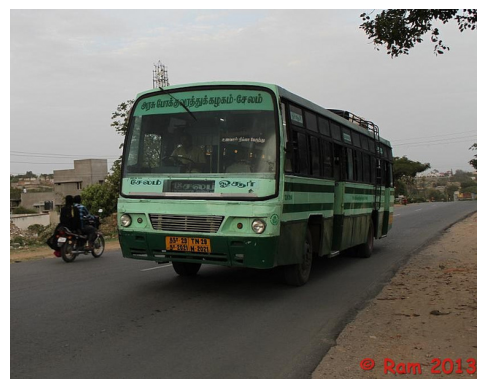

In [13]:
show_image(fill_image_path(226154,'val'))